#### PARTE 1

Para as questões a seguir, você deverá executar códigos em um notebook Jupyter, rodando em ambiente local, certifique-se que:

##### 1. Você está rodando em Python 3.9+.
Resposta: Python 3.14.0
##### 2. Você está usando um ambiente virtual:
Resposta: Anaconda
##### 3. Todas as bibliotecas usadas nesse exercícios estão instaladas em um ambiente virtual específico
##### 4. Gere um arquivo de requerimentos (requirements.txt) com os pacotes necessários. É necessário se certificar que a versão do pacote está disponibilizada.
##### 5. Tire um printscreen do ambiente que será usado rodando em sua máquina.
Resposta: ![image.png](attachment:b64952bc-2632-4c34-b119-a7c61c913a85.png)
##### 6. Disponibilize os códigos gerados, assim como os artefatos acessórios (requirements.txt) e instruções em um repositório GIT público. (se isso não for feito, o diretório com esses arquivos deverá ser enviado compactado no moodle).
https://github.com/jeaninfnet/infnet_pd_clusterizacao_1

#### PARTE 2

Para as questões a seguir, usaremos uma base de dados e faremos a análise exploratória dos dados, antes da clusterização.

##### 1. Baixe os dados disponibilizados na plataforma Kaggle sobre dados sócio-econômicos e de saúde que determinam o índice de desenvolvimento de um país. Esses dados estão disponibilizados através do link: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data
##### 2. Quantos países existem no dataset?
Resposta: 167 países
##### 3. Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?
Resposta: Na primeira imagem, vemos que a faixa dinâmica das features income e gdpp são muito maiores que as outras.
![image.png](attachment:adfc3bb4-976a-46cc-9ffd-4531e857ec2a.png)

Então, eu realizo um pré-processamento, removendo a coluna coutry (nome do país) e uso o StandardScaler para equilibrar os pesos das features.
![image.png](attachment:9f88ebd6-4db3-4308-9bc0-a2aca78cdfe0.png)
##### 4. Realize o pré-processamento adequado dos dados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')


df_original = pd.read_csv('data/Country-data.csv')

df = df_original.copy()
X = df.drop('country', axis=1)

In [2]:
num_paises = df['country'].nunique()
print(f"Quantidade de países no dataset: {num_paises}")

Quantidade de países no dataset: 167


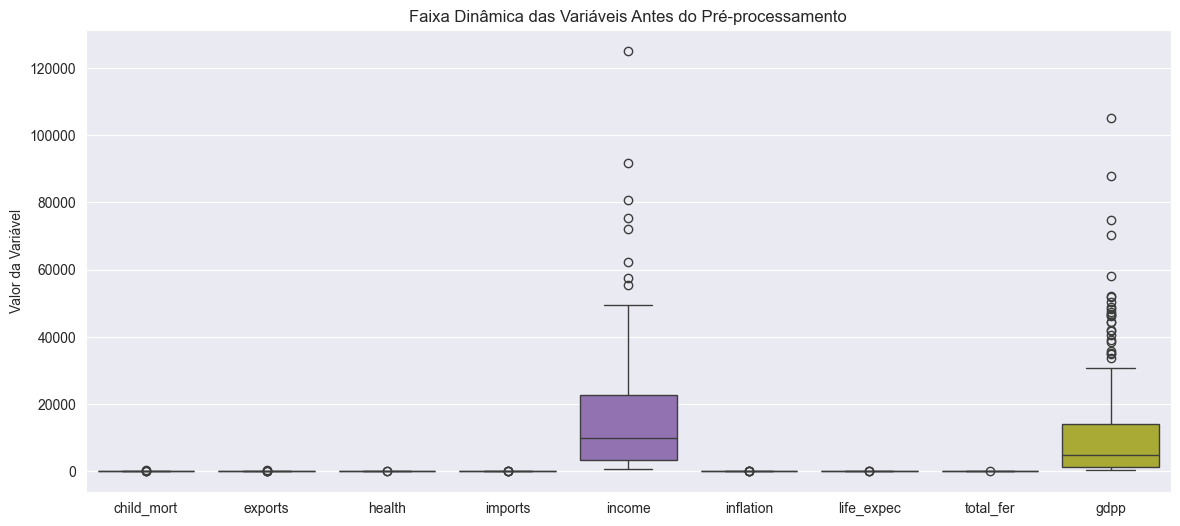


--- Estatísticas Descritivas (Escala) ---
                    mean           std
child_mort     38.270060     40.328931
exports        41.108976     27.412010
health          6.815689      2.746837
imports        46.890215     24.209589
income      17144.688623  19278.067698
inflation       7.781832     10.570704
life_expec     70.555689      8.893172
total_fer       2.947964      1.513848
gdpp        12964.155689  18328.704809


In [3]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=X)
plt.title('Faixa Dinâmica das Variáveis Antes do Pré-processamento')
plt.ylabel('Valor da Variável')
plt.show()

print("\n--- Estatísticas Descritivas (Escala) ---")
print(X.describe().loc[['mean', 'std']].T)

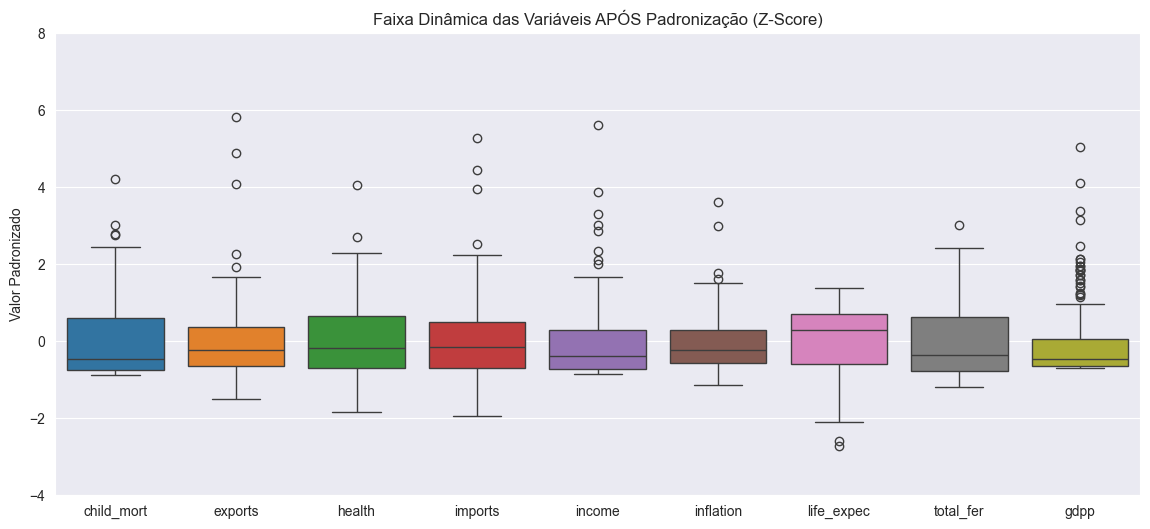

Dados pré-processados e prontos para clusterização (média ≈ 0, desvio-padrão ≈ 1).


In [4]:
scaler = StandardScaler()

X_scaled_array = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

plt.figure(figsize=(14, 6))
sns.boxplot(data=X_scaled)
plt.title('Faixa Dinâmica das Variáveis APÓS Padronização (Z-Score)')
plt.ylabel('Valor Padronizado')
plt.ylim(-4, 8)
plt.show()
print("Dados pré-processados e prontos para clusterização (média ≈ 0, desvio-padrão ≈ 1).")

#### PARTE 3

Para os dados pré-processados da etapa anterior você irá:

##### 1. Realizar o agrupamento dos países em 3 grupos distintos. Para tal, use:
##### a) K-Médias


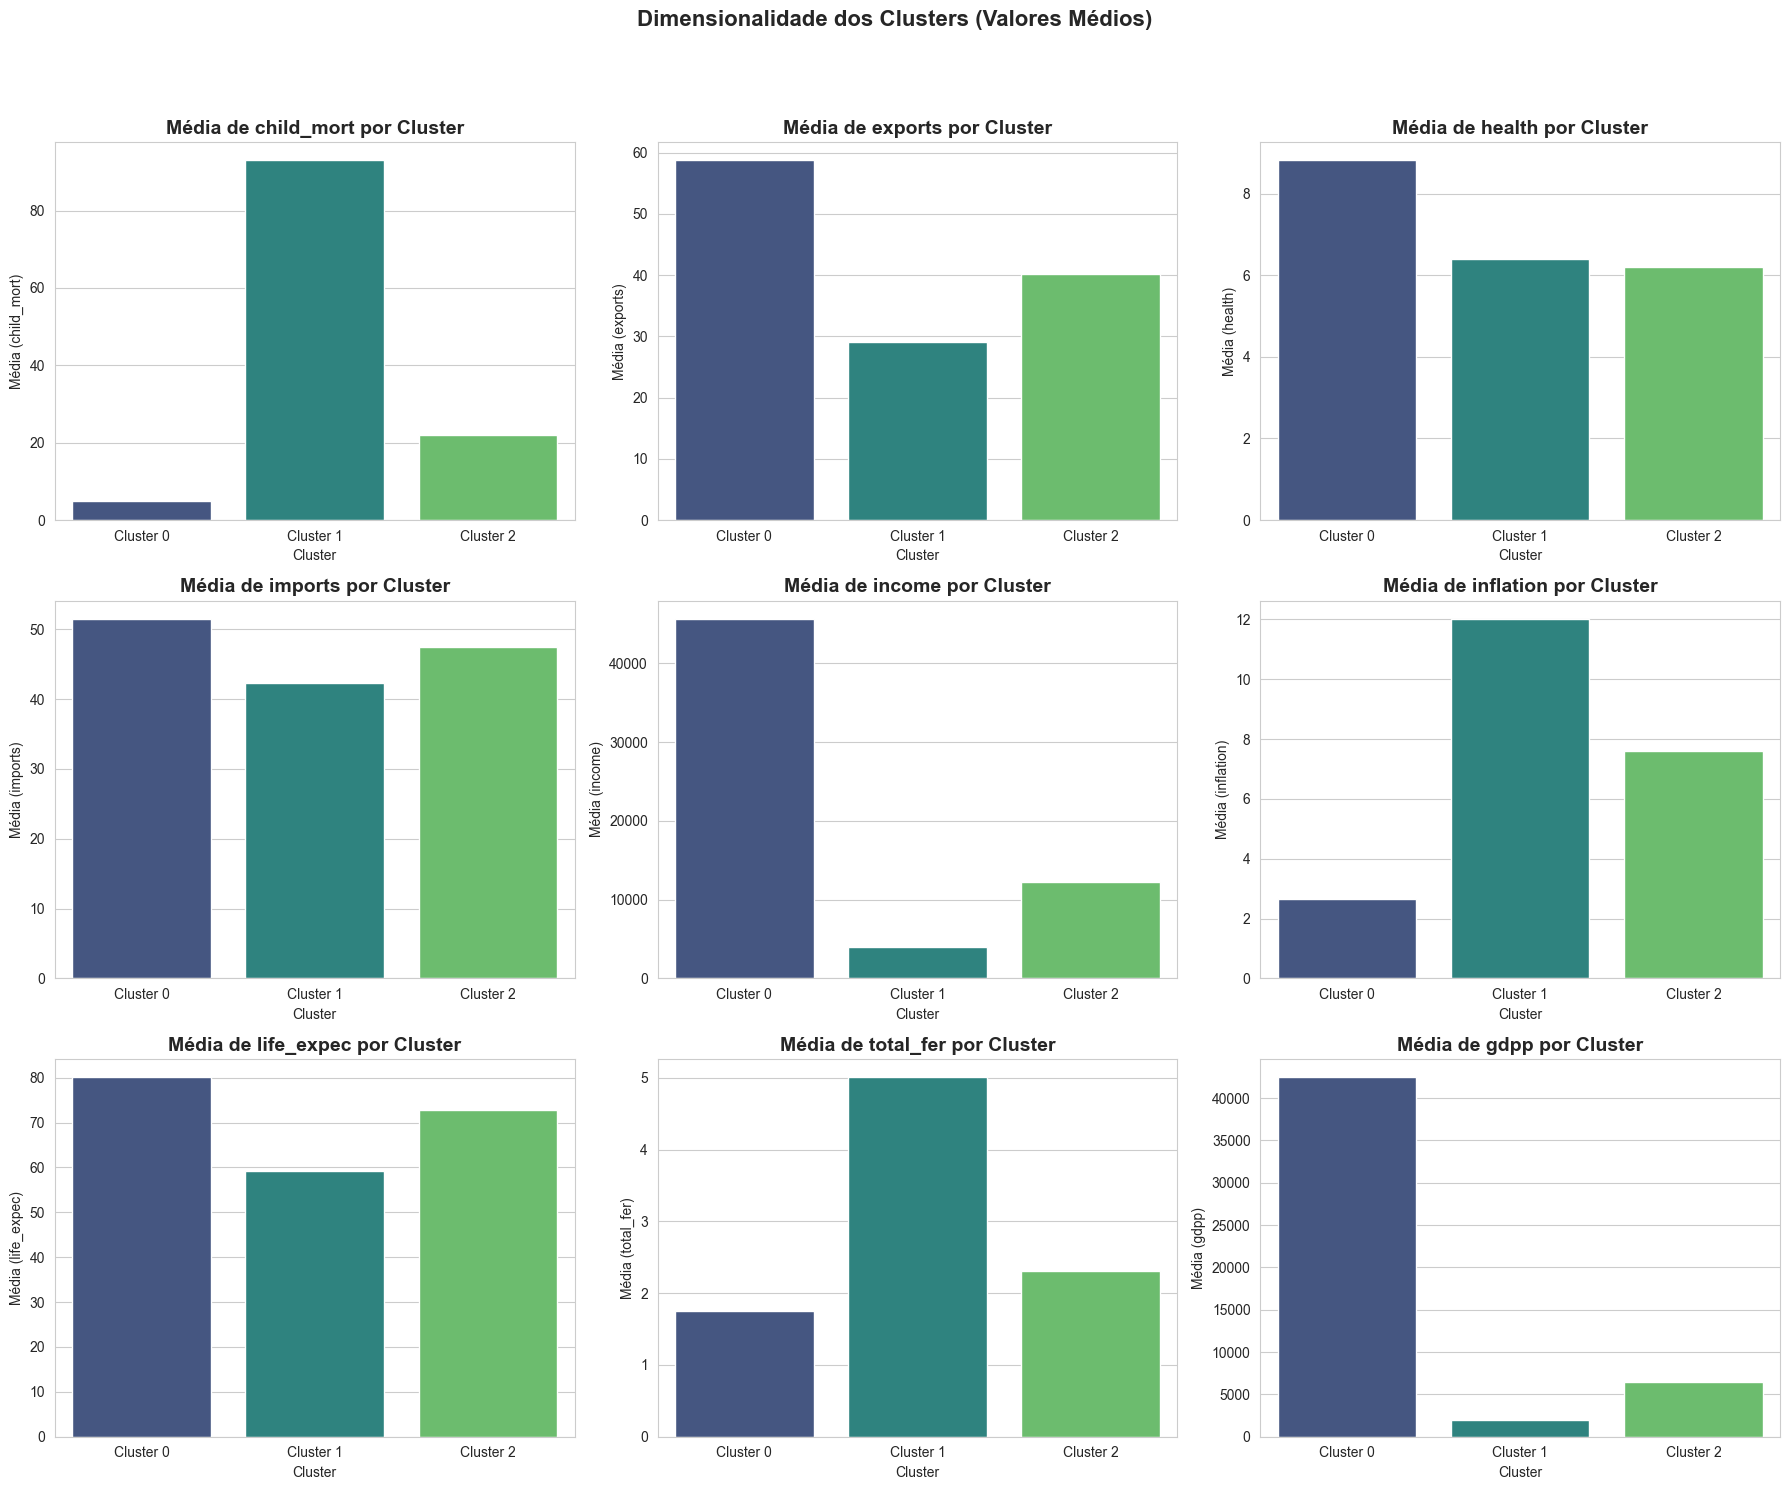

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_scaled)

df['KMeans_Cluster'] = kmeans.labels_

centroids_original = df.groupby('KMeans_Cluster')[X.columns].mean().round(2)

centroids_T = centroids_original.T.reset_index()
centroids_T.columns = ['Feature', 'Cluster 0', 'Cluster 1', 'Cluster 2']
centroids_long = centroids_T.melt(id_vars='Feature', var_name='Cluster', value_name='Mean_Value')

sns.set_style("whitegrid")
features = centroids_T['Feature'].unique()
n_features = len(features)
rows = (n_features + 2) // 3

fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))
axes = axes.flatten()

palette = sns.color_palette("viridis", n_colors=3)

for i, feature in enumerate(features):
    data_to_plot = centroids_long[centroids_long['Feature'] == feature]
    sns.barplot(x='Cluster', y='Mean_Value', data=data_to_plot, ax=axes[i], palette=palette)
    axes[i].set_title(f'Média de {feature} por Cluster', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(f'Média ({feature})')
    axes[i].ticklabel_format(style='plain', axis='y') # Evitar notação científica

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Dimensionalidade dos Clusters (Valores Médios)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajustar layout
plt.show()

In [6]:
paises_por_cluster = df.groupby('KMeans_Cluster')['country'].apply(list)

for cluster_id, paises in paises_por_cluster.items():
    print(f"--- CLUSTER {cluster_id} ({len(paises)} países) ---")

    if cluster_id == 0:
        descricao = "Alto Desenvolvimento (Baixa Mortalidade, Alto PIB/Renda)"
    elif cluster_id == 1:
        descricao = "Baixo Desenvolvimento (Alta Mortalidade, Baixo PIB/Renda)"
    else:
        descricao = "Desenvolvimento Intermediário/Emergente"

    print(f"{descricao}")
    print(paises)
    print("\n")

--- CLUSTER 0 (36 países) ---
Alto Desenvolvimento (Baixa Mortalidade, Alto PIB/Renda)
['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brunei', 'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Qatar', 'Singapore', 'Slovak Republic', 'Slovenia', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom', 'United States']


--- CLUSTER 1 (47 países) ---
Baixo Desenvolvimento (Alta Mortalidade, Baixo PIB/Renda)
['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Maurita

In [7]:
def find_medoid(X_data, labels, centroids):
    medoids = {}
    for cluster_id in np.unique(labels):
        cluster_points = X_data[labels == cluster_id]
        centroid = centroids[cluster_id]

        distances = cdist(cluster_points, [centroid], metric='euclidean')

        medoid_index_in_cluster = np.argmin(distances)

        medoid_original_index = cluster_points.index[medoid_index_in_cluster]

        medoid_country = df.loc[medoid_original_index, 'country']
        medoids[cluster_id] = medoid_country
    return medoids

medoids = find_medoid(X_scaled, df['KMeans_Cluster'].values, kmeans.cluster_centers_)

print("\n--- Medóides (Melhores Representantes) do K-Médias ---")
for k, v in medoids.items():
    print(f"Cluster {k}: {v}")


--- Medóides (Melhores Representantes) do K-Médias ---
Cluster 0: Iceland
Cluster 1: Guinea
Cluster 2: Jamaica


##### b) Clusterização Hierárquica


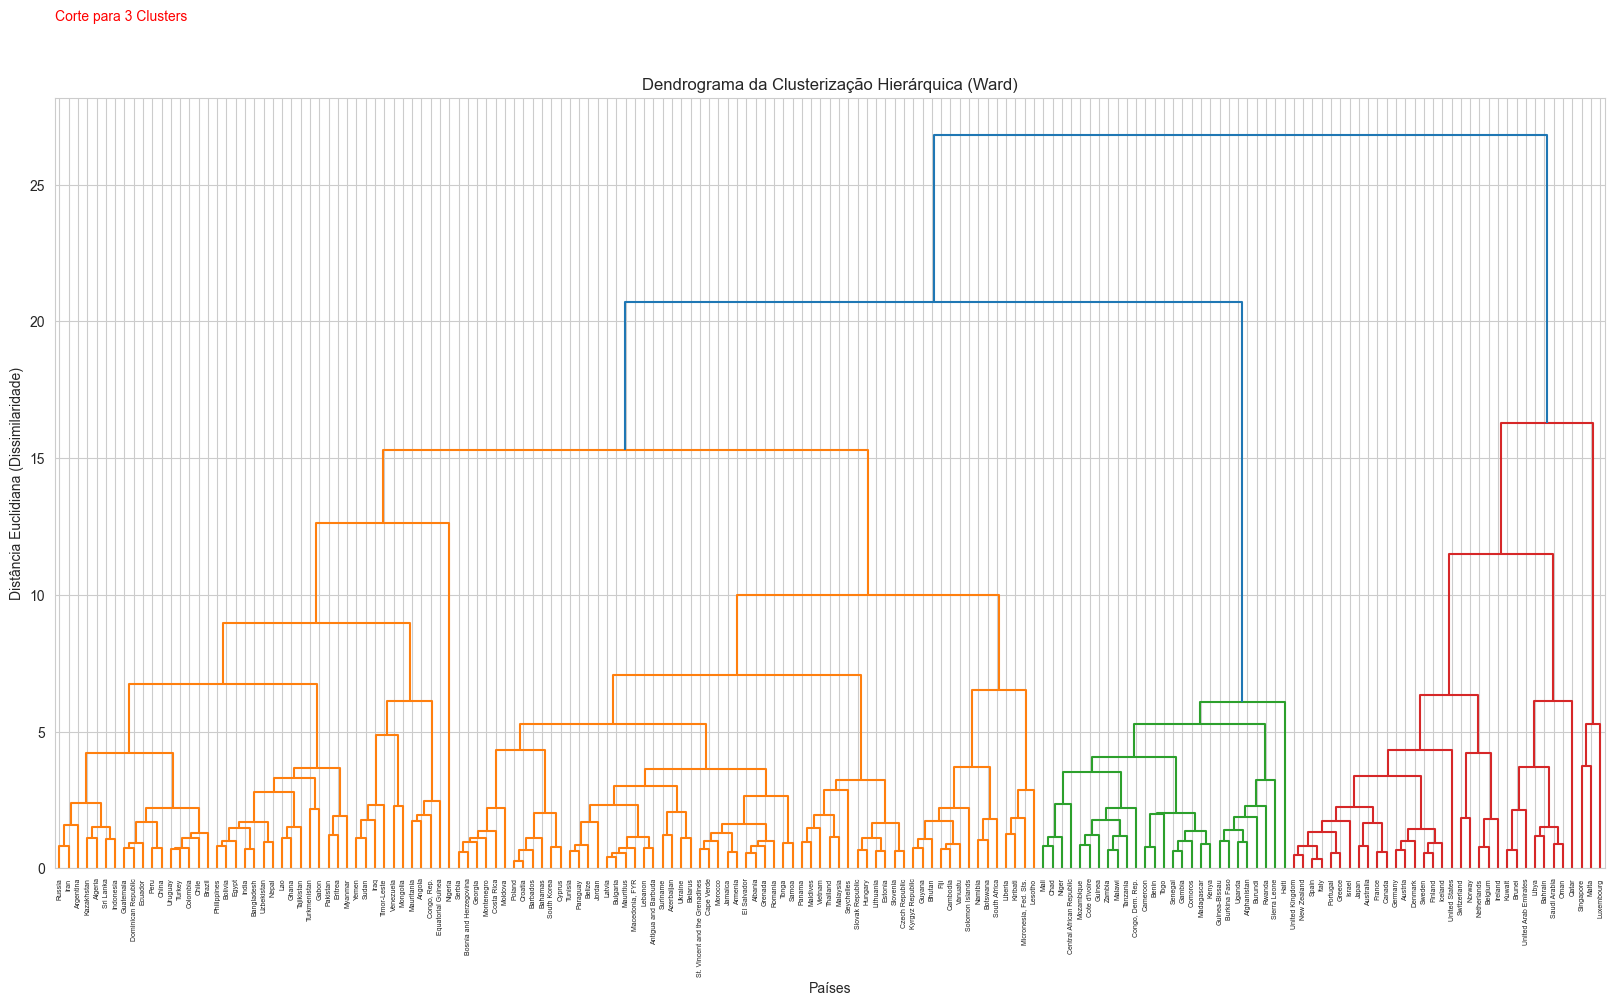

In [8]:
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(20, 10))
dendrogram(
    linked,
    orientation='top',
    labels=df['country'].values,
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Dendrograma da Clusterização Hierárquica (Ward)')
plt.xlabel('Países')
plt.ylabel('Distância Euclidiana (Dissimilaridade)')

plt.axhline(y=30, color='r', linestyle='--')
plt.text(0, 31, 'Corte para 3 Clusters', color='red')
plt.show()

##### 2. Para os resultados, do K-Médias:
##### a) Interprete cada um dos clusters obtidos citando:
##### i. Qual a distribuição das dimensões em cada grupo
![image.png](attachment:bf9dd945-1e74-4f51-aba5-be587f17c656.png)
![image.png](attachment:3258d5e6-70f5-4d32-b322-16cf6a47d773.png)
![image.png](attachment:748b2a7e-79ba-42af-ae68-3683eb718b8f.png)
![image.png](attachment:626d1db7-9349-4732-b8b3-d0a5075db145.png)


##### ii. O país, de acordo com o algoritmo, melhor representa o seu agrupamento. Justifique
Perfil: Países de Alto Desenvolvimento / Ricos. (Cluster 0)<br>
Justificativa: A Islândia é o representante ideal (Medoid) para este cluster. Seu perfil reflete as características médias deste grupo: baixa mortalidade infantil, alta renda per capita, alto PIB per capita e alta expectativa de vida.
<br>
<br>
Perfil: Países de Baixo Desenvolvimento / Pobres. (Cluster 1)<br>
Justificativa: Guiné é o representante ideal (Medoid) para este cluster. Seu perfil reflete as características médias deste grupo: altíssima mortalidade infantil, baixa renda e PIB per capita, baixa expectativa de vida e alta taxa de fertilidade.
<br>
<br>
Perfil: Países de Desenvolvimento Intermediário / Em Desenvolvimento. (Cluster 2)<br>
Justificativa: A Jamaica é o Medoid que melhor representa o perfil intermediário. Seu perfil está situado entre os extremos da Guiné (Cluster 1) e da Islândia (Cluster 0), caracterizando um país em desenvolvimento com indicadores sociais e econômicos moderados, que ainda não alcançaram o nível do Cluster 0, mas estão significativamente melhores que o Cluster 1.

##### 3. Para os resultados da Clusterização Hierárquica, apresente o dendograma e interprete os resultados
![image.png](attachment:dc33634b-5a88-42dc-8b1c-0d2fc83d98cc.png)
<br>
![image.png](attachment:bf36cc09-27cd-4aff-b0c3-81965f546cdc.png)
<br>
Basicamente, as duas formas estão com bastante concordância e o que poderia acontecer é que países ricos por exemplo que tenham indicadores sociais um pouco menores, serem movidos para o cluster de países em desenvolvimento.

#### PARTE 4

##### 1. Escreva em tópicos as etapas do algoritmo de K-médias até sua convergência.
<br>Inicialização: Definir o número de clusters (k) e atribuir k pontos de entrada aleatóriamente como os centróides do cluster.
<br>Atribuição de Cluster: Para cada um dos ponto criados, calcula-se a distância até cada um dos centróides e depois atribui-se o valor a ele.
<br> Atualização do Centróide: Para cada cluster, recalcular a posição do novo centróide, tomando a média de todos os outros pontos atribuídos a esse cluster na etapa de Atribuição de Cluster.
<br> Convergência: É repetida a etapa de Atribuição de Cluster e Atualização do Centróide até que seja atingido o máximo de iterações e os centróides não se movam mais.

##### 2. O algoritmo de K-médias converge até encontrar os centróides que melhor descrevem os clusters encontrados (até o deslocamento entre as interações dos centróides ser mínimo). Lembrando que o centróide é o baricentro do cluster em questão e não representa, em via de regra, um dado existente na base. Refaça o algoritmo apresentado na questão 1 a fim de garantir que o cluster seja representado pelo dado mais próximo ao seu baricentro em todas as iterações do algoritmo.
Obs: nesse novo algoritmo, o dado escolhido será chamado medóide.
<br>Inicialização: Definir o número de clusters (k) e atribuir k pontos reais dentro da base de entrada como os medóides do cluster.
<br>Atribuição de Cluster: Para cada um dos ponto criados, calcula-se a distância até cada um dos medóides e depois atribui-se o valor a ele.
<br> Atualização do Medóide: Para cada cluster e seu Medoide, o algoritmo tenta trocar o medóide por um outro ponto de dado do mesmo cluster que não seja medóide.
<br> Convergência: É Repetida a etapa de Atribuição de Cluster e Atualização do Medoide até que nenhuma troca de Medoide resulte em uma redução no custo total.

##### 3. O algoritmo de K-médias é sensível a outliers nos dados. Explique.
Os outliers são pontos que estão desproporcionalmente em uma extremidade, fazendo com que a média (centróides) é distorcida e não representando a real representação de um determinado cluster.

##### 4. Por que o algoritmo de DBScan é mais robusto à presença de outliers?
É mais robusto, pois ao encontrar um outlier. Ele acaba não correlacionando aquele ruído com algum cluster cluster.